<a href="https://colab.research.google.com/github/adityakulkarni0910/House_Price_Prediction/blob/main/House_Price_Prediction_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Results

Best model: vreg1 (Voting top 5)

Train rmse: 17355.699

Test rmse: 26913.579

# Data PreProcessing

In [ ]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.metrics import r2_score

pd.pandas.set_option('display.max_columns', None)
%matplotlib inline

### Load Datasets

In [ ]:

data = pd.read_csv('houseprice.csv')


### Types of variables



In [ ]:
# we have an Id variable, that we should not use for predictions:

print('Number of House Id labels: ', len(data.Id.unique()))
print('Number of Houses in the Dataset: ', len(data))

Number of House Id labels:  1460
Number of Houses in the Dataset:  1460


#### Find categorical variables

In [ ]:
# find categorical variables- hint data type = 'O'

categorical = [var for var in data.columns if data[var].dtype=='O']

print(f'There are {len(categorical)} categorical variables')

There are 43 categorical variables


#### Find temporal variables

In [ ]:
# make a list of the numerical variables first= Hint data type != O
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information= Hint variable namme has Yr or 
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

#### Find discrete variables

To identify discrete variables- numerical variables with less than 20 unique values 

In [ ]:
# let's visualise the values of the discrete variables
discrete = [var for var in numerical if len(data[var].unique()) < 20 and var not in year_vars]

print(f'There are {len(discrete)} discrete variables')

There are 14 discrete variables


#### Continuous variables

In [ ]:
# find continuous variables- hint numerical variables not in discrete and  year_years 
# Also remove the Id variable and the target variable SalePrice
# which are both also numerical

continuous = [var for var in numerical if var not in discrete and var not in [
    'Id', 'SalePrice'] and var not in year_vars]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 38 numerical and continuous variables


### Separate train and test set

In [ ]:
# Let's separate into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

**Now we will move on and engineer the features of this dataset. The most important part for this course.**

### Craete New Variables

Replace 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt  with time elapsed since YrSold
So YearBuilt = YrSold-YearBuilt. 

Similarly transform 'YearRemodAdd', 'GarageYrBlt.
After making transformation drop YrSold

In [ ]:
# function to calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [ ]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [ ]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [ ]:
year_vars.remove('YrSold')

In [ ]:
# capture the column names for use later in the notebook
final_columns = X_train.columns
final_columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### Feature Engineering Pipeline

In [ ]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [ ]:
# import relevant modules for feature engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from feature_engine.variable_transformers import YeoJohnsonTransformer
from sklearn.preprocessing import StandardScaler
from feature_engine.discretisers import DecisionTreeDiscretiser

In [ ]:
house_preprocess = Pipeline([
    
    # missing data imputation 
    ('missing_ind', mdi.AddNaNBinaryImputer(
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='mean',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    # categorical encoding 
     ('rare_label_enc', ce.RareLabelCategoricalEncoder(
         tol=0.01,n_categories=6, variables=categorical+discrete)),
    ('categorical_enc', ce.MeanCategoricalEncoder(variables = categorical + discrete)),
     
    # Transforming Numerical Variables
    ('yjt', YeoJohnsonTransformer(variables = ['LotFrontage','MasVnrArea', 'GarageYrBlt'])),

    
    # discretisation and encoding
    ('treeDisc',  DecisionTreeDiscretiser(cv=2, scoring='neg_mean_squared_error',
                                   regression=True,
                                   param_grid={'max_depth': [1,2,3,4,5,6]})),

    # feature Scaling
    ('scaler', StandardScaler()),
    
    

])

In [ ]:
house_preprocess.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('missing_ind',
                 AddNaNBinaryImputer(variables=['LotFrontage', 'MasVnrArea',
                                                'GarageYrBlt'])),
                ('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'MasVnrArea',
                                              'GarageYrBlt'])),
                ('imputer_cat',
                 CategoricalVariableImputer(variables=['MSZoning', 'Street',
                                                       'Alley', 'LotShape',
                                                       'LandContour',
                                                       'Utilities', '...
                                                    'Utilities', 'LotConfig',
                                                    'LandSlope', 'Neighborhood',
                                                    'Condition1', 'Condition2',
    

In [ ]:
# Apply Transformations
X_train=house_preprocess.transform(X_train)
X_test=house_preprocess.transform(X_test)

# Regression Models- Tune different models one by one

## Linear regression

In [ ]:
# Train a linear regression model, report the coefficients and model performance 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression().fit(X_train, y_train)
cv_scores = cross_val_score(lr, X_train, y_train)

# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(cv_scores))
print()
print("LR Performance Train: ", lr.score(X_train,y_train))
# Check test data set performance (changed: X_test and y_test)
print("LR Performance Test: ", lr.score(X_test,y_test))

Mean Cross-validation scores: [ 8.68335879e-01 -1.63333860e+22  8.76526862e-01  8.98295453e-01
  8.92144253e-01]

LR Performance Train:  0.9115066070570848
LR Performance Test:  0.8751535973227208


## Ridge

In [ ]:
# Train a Ridge regression model, report the coefficients, the best parameters, and model performance 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100,1000]}

grid_ridge = GridSearchCV(ridge, param_ridge, cv=10, return_train_score = True)
grid_ridge.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.3f}".format(grid_ridge.best_score_))

print()

#find best parameters
print('Ridge parameters: ', grid_ridge.best_params_)


#print("Ridge.coef_:", grid_ridge.best_estimator_.coef_)
#print("Ridge.intercept_:", grid_ridge.best_estimator_.intercept_)
print("Ridge Train Performance: ", grid_ridge.score(X_train,y_train))
# Check test data set performance

print("Ridge Test Performance: ", grid_ridge.score(X_test,y_test))

Best Mean Cross-validation score: 0.886

Ridge parameters:  {'alpha': 100}
Ridge Train Performance:  0.9103295889443213
Ridge Test Performance:  0.8731529205790173


## Lasso

In [ ]:
# Train a Lasso regression model, report the coefficients, the best parameters, and model performance 


from sklearn.linear_model import Lasso
lasso = Lasso(random_state=0)

#define a list of parameters (changed:added alpha=1000)
param_lasso = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100,1000,10000] }

grid_lasso = GridSearchCV(lasso, param_lasso, cv=10, return_train_score = True)
grid_lasso.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.3f}".format(grid_lasso.best_score_))
print()

#find best parameters
print('Lasso parameters: ', grid_lasso.best_params_)

# print co-eff

#print("Lasso.coef_:", grid_lasso.best_estimator_.coef_)
#print("Lasso.intercept_:", grid_lasso.best_estimator_.intercept_)
print("Lasso Train Performance: ", grid_lasso.score(X_train,y_train))
# Check test data set performance
print("Lasso Test Performance: ", grid_lasso.score(X_test,y_test))

Best Mean Cross-validation score: 0.886

Lasso parameters:  {'alpha': 1000}
Lasso Train Performance:  0.9053267125547907
Lasso Test Performance:  0.8865009634628674


## Elasticnet

In [ ]:
#ElasticNet Model

from sklearn.linear_model import ElasticNet

elasticnet = ElasticNet(max_iter=100000)

param_elasticnet = {'alpha':[0.001, 0.01, 0.1, 1, 10],'l1_ratio' :[0.2,0.4,0.6,0.8] }

grid_elasticnet = GridSearchCV(elasticnet , param_elasticnet, cv=10, return_train_score = True)
grid_elasticnet.fit(X_train, y_train)

print('Training set score: ', grid_elasticnet.score(X_train, y_train))

#find best parameters
print('Best parameters: ', grid_elasticnet.best_params_)
print('Best cross-validation score:', grid_elasticnet.best_score_)

print('Test score: ', grid_elasticnet.score(X_test, y_test))

Training set score:  0.9102377304004107
Best parameters:  {'alpha': 0.1, 'l1_ratio': 0.2}
Best cross-validation score: 0.886162500079646
Test score:  0.8730013625797748


## KNN

In [ ]:
#KNN regressor

from sklearn.neighbors import KNeighborsRegressor

knnreg = KNeighborsRegressor()

param_knn = {'n_neighbors': range(1,25)}

#apply grid search
grid_knn = GridSearchCV(knnreg, param_knn, cv=10, return_train_score=True)
grid_knn.fit(X_train, y_train)

print('train score: ', grid_knn.score(X_train, y_train))

#find best parameters
print('Best parameters: ', grid_knn.best_params_)
print('Best cross-validation score:', grid_knn.best_score_)

print('test score: ', grid_knn.score(X_test, y_test))

train score:  0.858046619738738
Best parameters:  {'n_neighbors': 8}
Best cross-validation score: 0.8114280972642354
test score:  0.7000160633674981


## Linear reg with SGD

In [ ]:
#linear regression with SGD

from sklearn.linear_model import SGDRegressor

reg_sgd = SGDRegressor(max_iter=1000, tol = 1e-5)

param_sgd = {'eta0':[0.01, 0.05, 0.1 ,0.5],'penalty' :['l1','l2','elasticnet'],'alpha' :[0.1,0.01,0.001]}

#apply grid search
grid_sgd = GridSearchCV(reg_sgd, param_sgd, cv=10, n_jobs=-1, return_train_score = True)
grid_sgd.fit(X_train, y_train)


#find best parameters
print('Best parameters: ', grid_sgd.best_params_)
print('Best cross-validation score:', grid_sgd.best_score_)

print('train score: ', grid_sgd.score(X_train, y_train))
print('test score: ', grid_sgd.score(X_test, y_test))


Best parameters:  {'alpha': 0.1, 'eta0': 0.01, 'penalty': 'l2'}
Best cross-validation score: 0.883605242735895
train score:  0.909058675963431
test score:  0.8714844856343241


## Polynomial

In [ ]:
#Polynomial regression

from sklearn.preprocessing  import PolynomialFeatures
from sklearn.pipeline import make_pipeline


poly = PolynomialFeatures()

param_poly = {'polynomialfeatures__degree':range(1,5)}
pipe_poly = make_pipeline(PolynomialFeatures(), LinearRegression())
grid_poly = GridSearchCV(pipe_poly, param_poly,cv=5, n_jobs=-1, return_train_score = True,scoring='r2')

grid_poly.fit(X_train, y_train)

#find best parameters
print('Best parameters: ', grid_poly.best_params_)


# print the coefficients
#print('Poly features: ', grid_poly.best_estimator_.named_steps['polynomialfeatures'].n_output_features_)
#print('Coefficients: ', grid_poly.best_estimator_.named_steps['linearregression'].coef_)

print('Best cross-validation score:', grid_poly.best_score_)

print('train score: ', grid_poly.score(X_train, y_train))
print('test score: ', grid_poly.score(X_test, y_test))

Best parameters:  {'polynomialfeatures__degree': 2}
Best cross-validation score: -4.885131197910408e+16
train score:  0.9999955966028627
test score:  -1.9061138988228244e+16


## Simple Support Vector Machine Regression


In [ ]:
#Simple Support Vector Machine Regression

from sklearn.svm import LinearSVR

svr_simple = LinearSVR()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_LinearSVR = GridSearchCV(svr_simple, param_grid, cv=10, return_train_score=True)
grid_LinearSVR.fit(X_train, y_train)


print("Best parameters: {}".format(grid_LinearSVR.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_LinearSVR.best_score_))

print('train score: ', grid_LinearSVR.score(X_train, y_train))
print('test score: ', grid_LinearSVR.score(X_test, y_test))

Best parameters: {'C': 100}
Best cross-validation score: -0.29
train score:  0.1474219673068904
test score:  0.1326105459554705


## SVM with Kernels

In [ ]:
#Support Vector Machine Regression with Kernels
from sklearn.svm import SVR

svr_kernel = SVR()
param_grid = [
 #           {'kernel': ['linear'],
#               'C': [0.001, 0.01, 0.1, 1, 10, 100]},
              
              {'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              
              {'kernel': ['poly'],
               'degree':range(1,5)},
              
              {'kernel': ['sigmoid']}]

grid_SVM = GridSearchCV(svr_kernel, param_grid, cv=5, return_train_score=True)
grid_SVM.fit(X_train, y_train)


print("Best parameters: {}".format(grid_SVM.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_SVM.best_score_))

print('train score: ', grid_SVM.score(X_train, y_train))
print('test score: ', grid_SVM.score(X_test, y_test))

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.04
train score:  0.06544572992203601
test score:  0.051943236974285045


## Decision Trees Regressor


In [ ]:
# Decision Trees Regressor

from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()

param_grid = {'max_depth': range(1,10),
           'min_samples_split': range(2,10,1)}

grid_tree = GridSearchCV(tree, param_grid, cv=5)
grid_tree.fit(X_train,y_train)


print("Best cross-validation score: {:.2f}".format(grid_tree.best_score_))
print(grid_tree.best_params_)
print('train score: ', grid_tree.score(X_train, y_train))
print('test score: ', grid_tree.score(X_test, y_test))


Best cross-validation score: 0.78
{'max_depth': 6, 'min_samples_split': 5}
train score:  0.8974588210964505
test score:  0.8120068395043382


# Tune Multiple Models with one GridSearch

In [ ]:
model_gs = Pipeline([("regressor", LinearRegression())])

In [ ]:
model_parm_gd = [
    { 'regressor': [LinearRegression()]},
    
    { 'regressor': [Ridge()],
      'regressor__alpha':[0.001, 0.01, 0.1, 1, 10, 100,200,1000] },
    
    { 'regressor': [Lasso(random_state=0)],
      'regressor__alpha':[0.001, 0.01, 0.1, 1, 10, 100,200,1000]},
    
    {'regressor': [ElasticNet(max_iter=100000)],
    'regressor__alpha':[0.001, 0.01, 0.1, 1, 10], 'regressor__l1_ratio' :[0.2,0.4,0.6,0.8]},
    
    {'regressor': [KNeighborsRegressor()],
    'regressor__n_neighbors': range(1,25)},
    
    {'regressor': [SGDRegressor(max_iter=1000, tol = 1e-5)],
    'regressor__eta0':[0.01, 0.05, 0.1 ,0.5], 'regressor__penalty' :['l1','l2','elasticnet'],'regressor__alpha' :[0.1,0.01,0.001]},
    
    {'regressor': [DecisionTreeRegressor()],
    'regressor__max_depth': range(1,10),
    'regressor__min_samples_split': range(2,10,1)}
     
]

In [ ]:
grid_search_house_pipe = GridSearchCV(model_gs, model_parm_gd)

In [ ]:
grid_search_house_pipe.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('regressor',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'regressor': [LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False)]},
                         {'regressor': [Ridge(alpha=1.0, copy...
                                                              max_leaf_nodes=None,
                                   

In [ ]:
print(grid_search_house_pipe.best_params_)

{'regressor': SGDRegressor(alpha=0.1, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=1e-05, validation_fraction=0.1, verbose=0,
             warm_start=False), 'regressor__alpha': 0.1, 'regressor__eta0': 0.01, 'regressor__penalty': 'l2'}


In [ ]:
# let's get the predictions
X_train_preds = grid_search_house_pipe.predict(X_train)
X_test_preds = grid_search_house_pipe.predict(X_test)

In [ ]:
print("Best Mean Cross-validation score: {:.3f}".format(grid_search_house_pipe.best_score_))

Best Mean Cross-validation score: 0.886


In [ ]:
# check model performance:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 568476991.6942252
train rmse: 23842.75553903586
train r2: 0.9089538278846372

test mse: 847559353.6050906
test rmse: 29112.872644331932
test r2: 0.8766668895599573


# Ensemble Models

## Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
bag_dtree1 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), bootstrap=True, random_state=0, oob_score=False)

bag_dtree1_param = {
                 'base_estimator__max_depth': range(1,10),
                'base_estimator__min_samples_split': range(2,10,1),
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}

bag_dtree1_grid = GridSearchCV(bag_dtree1, bag_dtree1_param,cv=5, return_train_score=True, )
bag_dtree1_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                             criterion='mse',
                                                                             max_depth=None,
                                                                             max_features=None,
                                                                             max_leaf_nodes=None,
                                                                             min_impurity_decrease=0.0,
                                                                             min_impurity_split=None,
                                                                             min_samples_leaf=1,
                                                                             min_samples_split=2,
                                                                             min_weight_fr

In [ ]:
print(f'Best Mean Cross Validation Score is {bag_dtree1_grid.best_score_}')
print(f'Best parameters are {bag_dtree1_grid.best_params_}')
print(f'Train score is {bag_dtree1_grid.score(X_train,y_train)}')
print(f'Test score is {bag_dtree1_grid.score(X_test,y_test)}')


Best Mean Cross Validation Score is 0.8722900792200419
Best parameters are {'base_estimator__max_depth': 9, 'base_estimator__min_samples_split': 2, 'max_samples': 0.8, 'n_estimators': 100}
Train score is 0.963722616694338
Test score is 0.8603296190869036


In [ ]:
bag_lasso = BaggingRegressor(base_estimator=Lasso(random_state=0), bootstrap=True, random_state=0, oob_score=False)

bag_lasso_param = {
                 'base_estimator__alpha': [1000],
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
bag_lasso_grid = GridSearchCV(bag_lasso, bag_lasso_param,cv=5, return_train_score=True, )
bag_lasso_grid.fit(X_train,y_train)

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=Lasso(alpha=1.0,
                                                             copy_X=True,
                                                             fit_intercept=True,
                                                             max_iter=1000,
                                                             normalize=False,
                                                             positive=False,
                                                             precompute=False,
                                                             random_state=0,
                                                             selection='cyclic',
                                                             tol=0.0001,
                                                             warm_start=False),
                                        bootstrap=True,
                                        bootstrap_features=F

In [ ]:
print(f'Best Mean Cross Validation Score is {bag_lasso_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {bag_lasso_grid.best_params_}')
print(f'Train score is {bag_lasso_grid.score(X_train,y_train)}')
print(f'Test score is {bag_lasso_grid.score(X_test,y_test)}')


Best Mean Cross Validation Score is 0.887194612876189
Best Mean Cross Validation Score is {'base_estimator__alpha': 1000, 'max_samples': 0.8, 'n_estimators': 10}
Train score is 0.9039907545280965
Test score is 0.8815220691055408


## Pasting

In [ ]:
paste_dtree1 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), bootstrap=False, random_state=0, oob_score=False)

paste_dtree1_param = {
                 'base_estimator__max_depth': range(1,10),
                'base_estimator__min_samples_split': range(2,10,1),
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}

paste_dtree1_grid = GridSearchCV(paste_dtree1, paste_dtree1_param,cv=5, return_train_score=True, )
paste_dtree1_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                             criterion='mse',
                                                                             max_depth=None,
                                                                             max_features=None,
                                                                             max_leaf_nodes=None,
                                                                             min_impurity_decrease=0.0,
                                                                             min_impurity_split=None,
                                                                             min_samples_leaf=1,
                                                                             min_samples_split=2,
                                                                             min_weight_fr

In [ ]:
print(f'Best Mean Cross Validation Score is {paste_dtree1_grid.best_score_}')
print(f'Best parameters are {paste_dtree1_grid.best_params_}')
print(f'Train score is {paste_dtree1_grid.score(X_train,y_train)}')
print(f'Test score is {paste_dtree1_grid.score(X_test,y_test)}')


Best Mean Cross Validation Score is 0.8567858212295105
Best parameters are {'base_estimator__max_depth': 9, 'base_estimator__min_samples_split': 5, 'max_samples': 0.8, 'n_estimators': 100}
Train score is 0.9726839066672325
Test score is 0.8549738009586612


In [ ]:
paste_lasso = BaggingRegressor(base_estimator=Lasso(random_state=0), bootstrap=False, random_state=0, oob_score=False)

paste_lasso_param = {
                 'base_estimator__alpha': [1000],
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}

paste_lasso_grid = GridSearchCV(paste_lasso, paste_lasso_param,cv=5, return_train_score=True, )
paste_lasso_grid.fit(X_train,y_train)

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\User\Anaconda3\envs\buan6341_2020\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tol

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=Lasso(alpha=1.0,
                                                             copy_X=True,
                                                             fit_intercept=True,
                                                             max_iter=1000,
                                                             normalize=False,
                                                             positive=False,
                                                             precompute=False,
                                                             random_state=0,
                                                             selection='cyclic',
                                                             tol=0.0001,
                                                             warm_start=False),
                                        bootstrap=False,
                                        bootstrap_features=

In [ ]:
print(f'Best Mean Cross Validation Score is {paste_lasso_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {paste_lasso_grid.best_params_}')
print(f'Train score is {paste_lasso_grid.score(X_train,y_train)}')
print(f'Test score is {paste_lasso_grid.score(X_test,y_test)}')


Best Mean Cross Validation Score is 0.8853500548849673
Best Mean Cross Validation Score is {'base_estimator__alpha': 1000, 'max_samples': 0.8, 'n_estimators': 10}
Train score is 0.904926603291563
Test score is 0.8840795669813257


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr =RandomForestRegressor(random_state=42)
rfr_param = { 
    'n_estimators': [10,25,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
   
}

rfr_grid = GridSearchCV(rfr, rfr_param,cv=5, return_train_score=True, )
rfr_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [ ]:
print(f'Best Mean Cross Validation Score is {rfr_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {rfr_grid.best_params_}')
print(f'Train score is {rfr_grid.score(X_train,y_train)}')
print(f'Test score is {rfr_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8684018451123624
Best Mean Cross Validation Score is {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}
Train score is 0.9518111754018606
Test score is 0.8620153277926287


## Extra-Trees

In [ ]:
from  sklearn.ensemble import ExtraTreesRegressor

In [ ]:
etr= ExtraTreesRegressor(random_state=42)
etr_param = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
}
etr_grid = GridSearchCV(etr, etr_param,cv=5, return_train_score=True, )
etr_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=42,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param

In [ ]:
print(f'Best Mean Cross Validation Score is {etr_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {etr_grid.best_params_}')
print(f'Train score is {etr_grid.score(X_train,y_train)}')
print(f'Test score is {etr_grid.score(X_test,y_test)}')


Best Mean Cross Validation Score is 0.8670305610889916
Best Mean Cross Validation Score is {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Train score is 0.9727567527434288
Test score is 0.8552179473762773


## Ada Boost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
adr_dtree =AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),random_state=42)
adr_dtree_param = {
              'base_estimator__splitter' :   ["best", "random"],
              'base_estimator__max_depth' : [2,4,6],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2],
             }
adr_dtree_grid = GridSearchCV(adr_dtree, adr_dtree_param,cv=5, return_train_score=True, )
adr_dtree_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                              criterion='mse',
                                                                              max_depth=None,
                                                                              max_features=None,
                                                                              max_leaf_nodes=None,
                                                                              min_impurity_decrease=0.0,
                                                                              min_impurity_split=None,
                                                                              min_samples_leaf=1,
                                                                              min_samples_split=2,
                                                                              min

In [ ]:
print(f'Best Mean Cross Validation Score is {adr_dtree_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {adr_dtree_grid.best_params_}')
print(f'Train score is {adr_dtree_grid.score(X_train,y_train)}')
print(f'Test score is {adr_dtree_grid.score(X_test,y_test)}')


Best Mean Cross Validation Score is 0.8731237811314138
Best Mean Cross Validation Score is {'base_estimator__max_depth': 6, 'base_estimator__splitter': 'best', 'learning_rate': 2, 'n_estimators': 100}
Train score is 0.9623020124499386
Test score is 0.8698379324389934


## Gradient Boost

In [ ]:
from  sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbr= GradientBoostingRegressor(random_state=42)
gbr_param = {
              'max_depth' : [2,3,4],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2],
             }
gbr_grid = GridSearchCV(gbr, gbr_param,cv=5, return_train_score=True, )
gbr_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [ ]:
print(f'Best Mean Cross Validation Score is {gbr_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {gbr_grid.best_params_}')
print(f'Train score is {gbr_grid.score(X_train,y_train)}')
print(f'Test score is {gbr_grid.score(X_test,y_test)}')


Best Mean Cross Validation Score is 0.8693214037454589
Best Mean Cross Validation Score is {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
Train score is 0.9845482194901631
Test score is 0.8834970768587678


## XGBoost

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


In [ ]:
xgbr= XGBRegressor(random_state=42,early_stopping_rounds=2)
xgbr_param = {
              'max_depth' : [2,4,6],
              'n_estimators' : [50,100,150],
              'learning_rate' : [0.1,0.5,0.6,0.8],
               'min_child_weight' : [1,3,5,7],
                'subsample':[0.6,0.7,0.8,0.9,1]
             }
xgbr_grid = GridSearchCV(xgbr, xgbr_param,cv=5, return_train_score=True, )
xgbr_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=2, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_c...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_gri

In [ ]:
print(f'Best Mean Cross Validation Score is {xgbr_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {xgbr_grid.best_params_}')
print(f'Train score is {xgbr_grid.score(X_train,y_train)}')
print(f'Test score is {xgbr_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8981992683459357
Best Mean Cross Validation Score is {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.8}
Train score is 0.979396879296572
Test score is 0.8776048030903614


# Summary

In [ ]:
Regressors={'linreg':lr,
             'ridge':grid_ridge,
             'lasso':grid_lasso,
             'elasticnet':grid_elasticnet,
             'knn':grid_knn,
             'SGD':grid_sgd,
             'Poly':grid_poly,
             'LinearSVR':grid_LinearSVR,
             'SVM':grid_SVM,
             'dtree':grid_tree,
             'bag_dtree1':bag_dtree1_grid,
             'bag_lasso':bag_lasso_grid,
            'paste_dtree1': paste_dtree1_grid,
             'paste_lasso':paste_lasso_grid,
             'rfr': rfr_grid,
             'etr': etr_grid,
             'adr_dtree':adr_dtree_grid,
             'gbr': gbr_grid,
             'xgbr': xgbr_grid}

In [ ]:
Regressors.keys()

dict_keys(['linreg', 'ridge', 'lasso', 'elasticnet', 'knn', 'SGD', 'Poly', 'LinearSVR', 'SVM', 'dtree', 'bag_dtree1', 'bag_lasso', 'paste_dtree1', 'paste_lasso', 'rfr', 'etr', 'adr_dtree', 'gbr', 'xgbr'])

In [ ]:
results_mean_std = []
for  key, value in Regressors.items():
    r2_train = "{:.3f}".format(value.score(X_train,y_train))
    r2_test = "{:.3f}".format(value.score(X_test,y_test))

#    r2="{:.3f}".format(grid_SVC.best_score_))
#    std=value.r2_score['std_test_score'][value.best_index_]
     
    results_mean_std.append({
        "model": key,
        "r2_train": r2_train,
        "r2_test":r2_test
#        "std": std
    })

In [ ]:
# Create a Pandas DataFrame with the r2 results
accuracy_df = pd.DataFrame(results_mean_std, columns=['model', 'r2_train','r2_test'])


In [ ]:
# Show the accuracy dataframe

accuracy_df.sort_values(by=['r2_test'], inplace=True,ascending=False)
accuracy_df

,model,r2_train,r2_test
2,lasso,0.905,0.887
13,paste_lasso,0.905,0.884
17,gbr,0.985,0.883
11,bag_lasso,0.904,0.882
18,xgbr,0.979,0.878
0,linreg,0.912,0.875
1,ridge,0.910,0.873
3,elasticnet,0.910,0.873
5,SGD,0.909,0.871
16,adr_dtree,0.962,0.870


In [ ]:
# Create a prediction of all models on the test set
predictions_all = {}
for  key, value in Regressors.items():
    if key == 'linreg':
        predictions = lr.predict(X_test)
    else:
    # Get best estimator
        best_model = value.best_estimator_

        # Predict test labels
        predictions = best_model.predict(X_test)

        # Save predictions to a list
    predictions_all[key] = predictions
        

In [ ]:
# Creat a DataFrame for the predictions
pred = pd.DataFrame(predictions_all)

Text(0.5, 1, 'Correlation of the test set label prediction between models')

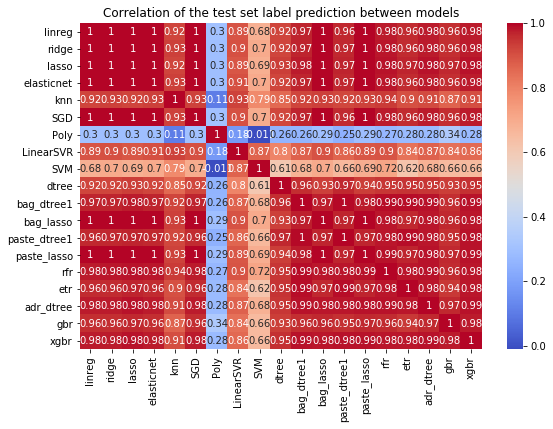

In [ ]:
# Plot a heatmap of all correlations for easier visualization
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
g = sns.heatmap(pred.corr(), annot=True, cmap='coolwarm', ax=ax)
g.set_title('Correlation of the test set label prediction between models')

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]



In [ ]:
#Due to its bad score, I decided to exclude 'Poly' from the list of models
print("Top Absolute Correlations")
print(get_top_abs_correlations(pred, 22))

Top Absolute Correlations
Poly        SVM             0.010551
knn         Poly            0.106446
Poly        LinearSVR       0.175106
            paste_dtree1    0.248513
            dtree           0.255745
            bag_dtree1      0.260057
            rfr             0.266623
            etr             0.278857
            xgbr            0.278920
            adr_dtree       0.281145
            paste_lasso     0.290083
            bag_lasso       0.294792
elasticnet  Poly            0.295801
ridge       Poly            0.296204
lasso       Poly            0.297135
linreg      Poly            0.303519
SGD         Poly            0.304847
Poly        gbr             0.337529
SVM         dtree           0.611096
            etr             0.624905
            xgbr            0.655726
            gbr             0.656138
dtype: float64


# Stacking

## Voting top 5

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
vreg1 = VotingRegressor(estimators=
                              [('lasso',grid_lasso.best_estimator_), 
                               ('paste_lasso', paste_lasso_grid.best_estimator_), 
                               ('gbr', gbr_grid.best_estimator_),
                               ('bag_lasso', bag_lasso_grid.best_estimator_),
                               ('xgbr', xgbr_grid.best_estimator_)
                              ], )
vreg1_param = {}

vreg1_grid = GridSearchCV(vreg1, vreg1_param, cv=5, return_train_score=True, )
vreg1_grid.fit(X_train,y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=VotingRegressor(estimators=[('lasso',
                                                    Lasso(alpha=1000,
                                                          copy_X=True,
                                                          fit_intercept=True,
                                                          max_iter=1000,
                                                          normalize=False,
                                                          positive=False,
                                                          precompute=False,
                                                          random_state=0,
                                                          selection='cyclic',
                                                          tol=0.0001,
                                                          warm_start=False)),
                                                   ('paste_lasso',
                   

In [ ]:
print(f'Best Mean Cross Validation Score is {vreg1_grid.best_score_}')
print(f'Train score is {vreg1_grid.score(X_train,y_train)}')
print(f'Test score is {vreg1_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8998012968049606
Train score is 0.9517571428837854
Test score is 0.8945971180338332


## Voting Least correlated

In [ ]:
vreg2 = VotingRegressor(estimators=
                              [('SVM', grid_SVM.best_estimator_), 
                               ('dtree', grid_tree.best_estimator_), 
                               ('etr', etr_grid.best_estimator_), 
                               ('xgbr', xgbr_grid.best_estimator_), 
                               ('gbr', gbr_grid.best_estimator_),
                              ], )
vreg2_param = {}

vreg2_grid = GridSearchCV(vreg2, vreg2_param,cv=5, return_train_score=True, )
vreg2_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=VotingRegressor(estimators=[('SVM',
                                                    SVR(C=100, cache_size=200,
                                                        coef0=0.0, degree=3,
                                                        epsilon=0.1, gamma=0.01,
                                                        kernel='rbf',
                                                        max_iter=-1,
                                                        shrinking=True,
                                                        tol=0.001,
                                                        verbose=False)),
                                                   ('dtree',
                                                    DecisionTreeRegressor(ccp_alpha=0.0,
                                                                          criterion='mse',
                                                                          ma

In [ ]:
print(f'Best Mean Cross Validation Score is {vreg2_grid.best_score_}')
print(f'Train score is {vreg2_grid.score(X_train,y_train)}')
print(f'Test score is {vreg2_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8412137343916051
Train score is 0.9292818705859918
Test score is 0.8467495784347077


## Stacking top 5

In [ ]:
from sklearn.ensemble import StackingRegressor

In [ ]:
sreg1 = StackingRegressor(estimators=
                              [('lasso',grid_lasso.best_estimator_), 
                               ('paste_lasso', paste_lasso_grid.best_estimator_), 
                               ('gbr', gbr_grid.best_estimator_),
                               ('bag_lasso', bag_lasso_grid.best_estimator_),
                               ('xgbr', xgbr_grid.best_estimator_)
                              ], )
sreg1_param = {}

sreg1_grid = GridSearchCV(sreg1, sreg1_param,cv=5, return_train_score=True, )
sreg1_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingRegressor(cv=None,
                                         estimators=[('lasso',
                                                      Lasso(alpha=1000,
                                                            copy_X=True,
                                                            fit_intercept=True,
                                                            max_iter=1000,
                                                            normalize=False,
                                                            positive=False,
                                                            precompute=False,
                                                            random_state=0,
                                                            selection='cyclic',
                                                            tol=0.0001,
                                                            warm_start=False)),
            

In [ ]:
print(f'Best Mean Cross Validation Score is {sreg1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sreg1_grid.best_params_}')
print(f'Train score is {sreg1_grid.score(X_train,y_train)}')
print(f'Test score is {sreg1_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8994362380676233
Best Mean Cross Validation Score is {}
Train score is 0.9689847317519205
Test score is 0.8907223052883766


## Stacking Least Correlated

In [ ]:
sreg2 = StackingRegressor(estimators=
                              [('SVM', grid_SVM.best_estimator_), 
                               ('dtree', grid_tree.best_estimator_), 
                               ('etr', etr_grid.best_estimator_), 
                               ('xgbr', xgbr_grid.best_estimator_), 
                               ('gbr', gbr_grid.best_estimator_),
                              ], )
sreg2_param = {}

sreg2_grid = GridSearchCV(sreg2, sreg2_param,cv=5, return_train_score=True, )
sreg2_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingRegressor(cv=None,
                                         estimators=[('SVM',
                                                      SVR(C=100, cache_size=200,
                                                          coef0=0.0, degree=3,
                                                          epsilon=0.1,
                                                          gamma=0.01,
                                                          kernel='rbf',
                                                          max_iter=-1,
                                                          shrinking=True,
                                                          tol=0.001,
                                                          verbose=False)),
                                                     ('dtree',
                                                      DecisionTreeRegressor(ccp_alpha=0.0,
                                     

In [ ]:
print(f'Best Mean Cross Validation Score is {sreg2_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sreg2_grid.best_params_}')
print(f'Train score is {sreg2_grid.score(X_train,y_train)}')
print(f'Test score is {sreg2_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8988083000041686
Best Mean Cross Validation Score is {}
Train score is 0.9829054591050093
Test score is 0.8849320496458035


# Result

In [ ]:
all_models={'linreg':lr,
             'ridge':grid_ridge,
             'lasso':grid_lasso,
             'elasticnet':grid_elasticnet,
             'knn':grid_knn,
             'SGD':grid_sgd,
             'Poly':grid_poly,
             'LinearSVR':grid_LinearSVR,
             'SVM':grid_SVM,
             'dtree':grid_tree,
             'bag_dtree1':bag_dtree1_grid,
             'bag_lasso':bag_lasso_grid,
             'paste_dtree1': paste_dtree1_grid,
             'paste_lasso':paste_lasso_grid,
             'rfr': rfr_grid,
             'etr': etr_grid,
             'adr_dtree':adr_dtree_grid,
             'gbr': gbr_grid,
             'xgbr': xgbr_grid,
             'vreg1': vreg1_grid,
             'vreg2': vreg2_grid,
             'sreg1': sreg1_grid,
             'sreg2': sreg2_grid,
            }

In [ ]:
results_r2_cv = []
for  key, value in all_models.items():
    if key != 'linreg':    
        r2_test = "{:.3f}".format(value.score(X_test,y_test))
        cv_score = "{:.3f}".format(value.best_score_)

        results_r2_cv.append({
            "model": key,
            "r2_test":r2_test,
            "cv_score":cv_score
    })

In [ ]:
results_r2_cv_df = pd.DataFrame(results_r2_cv, columns=['model', 'r2_test','cv_score'])

# Show the r2_cv_score dataframe

results_r2_cv_df.sort_values(by=['r2_test'], inplace=True,ascending=False)
results_r2_cv_df

,model,r2_test,cv_score
18,vreg1,0.895,0.900
20,sreg1,0.891,0.899
1,lasso,0.887,0.886
21,sreg2,0.885,0.899
12,paste_lasso,0.884,0.885
16,gbr,0.883,0.869
10,bag_lasso,0.882,0.887
17,xgbr,0.878,0.898
0,ridge,0.873,0.886
2,elasticnet,0.873,0.886


In [ ]:
#Best model on r2_test and CV score: vreg1 (Voting top 5)

# let's get the predictions
X_train_preds = vreg1_grid.predict(X_train)
X_test_preds = vreg1_grid.predict(X_test)

print('train rmse: {:.3f}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('test rmse: {:.3f}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))


train rmse: 17355.699
test rmse: 26913.579
